# Курсовой проект для курса "Python для Data Science"

**Задание:** Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

**Целевая переменная:** Price

**Метрика:** R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Описание датасета:**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

## I. Загрузка библиотек и функций

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from lightgbm import LGBMRegressor

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для применения текущей даты
from datetime import date

# 6. Cборщик мусора
import gc 

# 7. Понижение размерности
from sklearn.decomposition import PCA

In [2]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 5000], [0, 5000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## II. Чтение данных

In [3]:
df = pd.read_csv('train.csv')
fdf = pd.read_csv('test.csv')

In [4]:
# Проверка типов данных train
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [5]:
# Проверка типов данных test
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


## III. EDA и чистка данных

### III.I. Преобразование идентификационных и категориальных параметров

In [6]:
# DistrictId
df['DistrictId'] = df['DistrictId'].astype('category')
fdf['DistrictId'] = fdf['DistrictId'].astype('category')

# Ecology_2
df['Ecology_2'] = df['Ecology_2'].map({'A': 0, 'B': 1})
fdf['Ecology_2'] = fdf['Ecology_2'].map({'A': 0, 'B': 1})

# Ecology_3
df['Ecology_3'] = df['Ecology_3'].map({'A': 0, 'B': 1})
fdf['Ecology_3'] = fdf['Ecology_3'].map({'A': 0, 'B': 1})

# Shops_2
df['Shops_2'] = df['Shops_2'].map({'A': 0, 'B': 1})
fdf['Shops_2'] = fdf['Shops_2'].map({'A': 0, 'B': 1})

In [7]:
df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


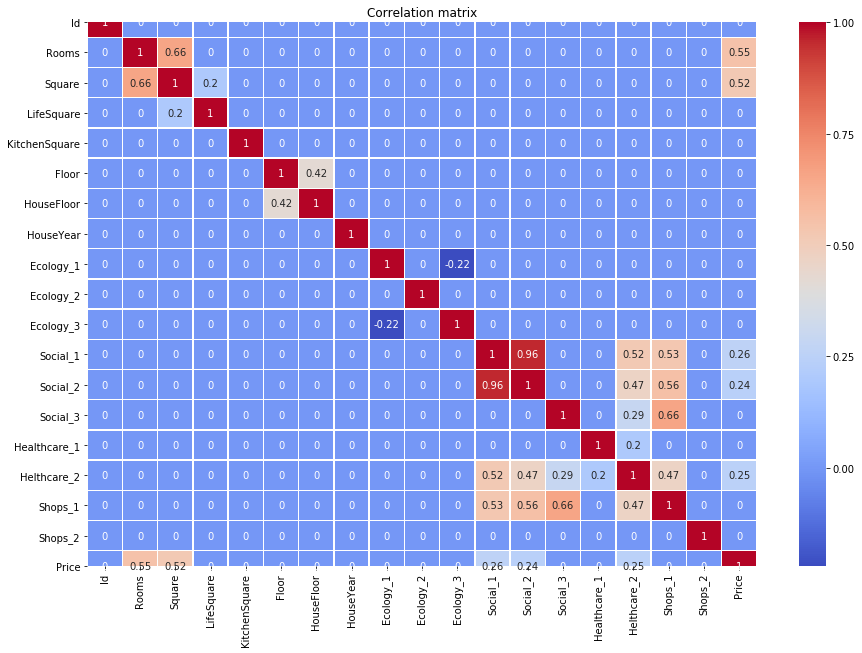

In [8]:
plt.figure(figsize = (15,10))

sns.plotting_context(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### III.II. Выявление и исправление выбросов и чистка данных

**HouseYear**

In [9]:
df.HouseYear.sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

*Подозрение вызывают признаки больше текущего года*

**Floor и HouseFloor**

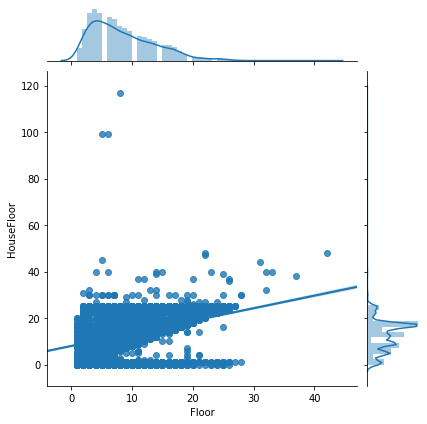

In [10]:
grid = sns.jointplot(df['Floor'], df['HouseFloor'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

*Подозрение вызывают признаки этажность больше 90 и этаж больше этажности дома*

In [11]:
df.loc[df['Floor'] > df['HouseFloor']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,1,1,5,1227,0,NaN,0,0,1,117000.381287
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1,127200.026511
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,571069.052600


**Rooms**

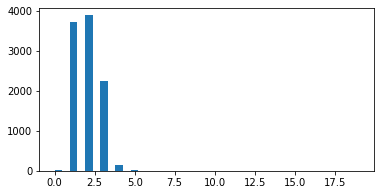

In [12]:
plt.figure(figsize = (6, 3))
plt.hist(df.Rooms, bins=40)
plt.show()

*Подозрение вызывают признаки 0 и больше 5*

**Square и LifeSquare**

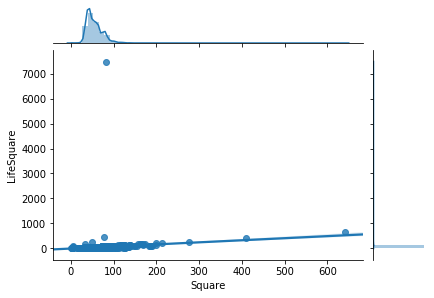

In [13]:
grid = sns.jointplot(df['Square'], df['LifeSquare'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(4)
plt.show()

*Подозрение вызывают признаки меньше 12 на 1 комнату, площадь больше 300 и жилая площадь больше площади всей квартиры*

**KitchenSquare**

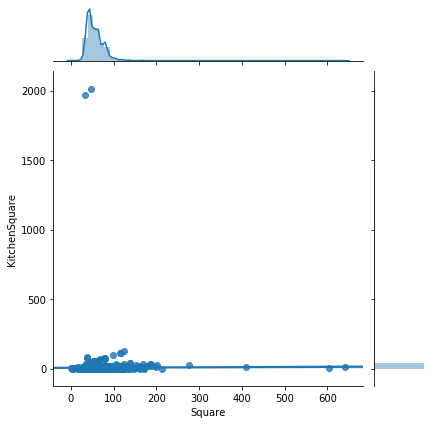

In [14]:
grid = sns.jointplot(df['Square'], df['KitchenSquare'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

*Подозрение вызывают признаки меньше 3 и больше половины площади квартиры*

In [15]:
def correction(X):
    
    # HouseYear    
    # выброс заполнить модой 
    X.loc[X['HouseYear'] > float(date.today().strftime('%Y')), 'HouseYear'] = X['HouseYear'].mode()[0]
    
    # Floor и HouseFloor
    # выброс заполнить медианой
    X.loc[X['HouseFloor'] > 90, 'HouseFloor'] = X['HouseFloor'].median()
    # поменять местами этаж и этажность если HouseFloor не равен нулю
    param_f = (X['Floor'] > X['HouseFloor']) & (X['HouseFloor'] != 0)
    X.loc[param_f, 'HouseFloor'], X.loc[param_f, 'Floor'] = X.loc[param_f, 'Floor'], X.loc[param_f, 'HouseFloor']
    # этажность заменить на этаж
    X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'] = X.loc[X['Floor'] > X['HouseFloor'], 'Floor']

    # Rooms
    # заполнить на основании медиан площади в разрезе количества комнат
    #X['R_old'] = X['Rooms']
    X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 5)) & (X['Square'] <= 48), 'Rooms'] = 1
    X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 5)) & (X['Square'] > 48) & (X['Square'] <= 68), 'Rooms'] = 2
    X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 5)) & (X['Square'] > 68) & (X['Square'] <= 88), 'Rooms'] = 3
    X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 5)) & (X['Square'] > 88) & (X['Square'] <= 118), 'Rooms'] = 4
    X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 5)) & (X['Square'] > 118), 'Rooms'] = 5
    
    # LifeSquare
    # словарь - медиана площади LifeSquare в разрезе комнат в квартире
    med_r_ls = X.groupby('Rooms')['LifeSquare'].median().round(2).to_dict()
    # исправление выбросов площади квартиры на основании словаря med_r_ls
    param = (X['LifeSquare'] > 300)
    X.loc[param, 'LifeSquare'] = X.loc[param, 'Rooms'].map(med_r_ls)

    # Square
    #X['S_old'] = X['Square']
    X.loc[X['Square'] > 300, 'Square'] = X.loc[X['Square'] > 300, 'Square'] / 10
    X.loc[X['Square'] < 10, 'Square'] = X.loc[X['Square'] < 10, 'Square'] * 10
    param_s1 = (X['Square']< X['LifeSquare'])
    X.loc[param_s1, 'Square'], X.loc[param_s1, 'LifeSquare'] = X.loc[param_s1, 'LifeSquare'], X.loc[param_s1, 'Square']
    # категория площади
    X['S_cat'] = X['Square']//10*10
    # словарь - медиана Rooms в разрезе категории площади по данным train
    med_sc_r = X.groupby('S_cat')['Rooms'].median().round(2).to_dict()
    #исправление выбросов площади квартиры на основании словаря med_r_s
    param_s2 = ((X['Square'] / X['Rooms']) < 12)
    X.loc[param_s2, 'Rooms'] = X.loc[param_s2, 'S_cat'].map(med_sc_r)
    X.drop('S_cat', axis=1, inplace=True)
    
    # KitchenSquare
    #X['KS_old'] = X['KitchenSquare']
    # словарь - медиана площади KitchenSquare в разрезе комнат в квартире по данным train
    med_r_ks = df.groupby('Rooms')['KitchenSquare'].median().round(2).to_dict()
    X['med_R_KS'] = X['Rooms'].map(med_r_ks)
    # исправление выбросов площади KitchenSquare на основании словаря med_r_ks
    param_k = (X['KitchenSquare'] < 3) | (X['KitchenSquare'] > (X['Square'] / 2))
    X.loc[param_k, 'KitchenSquare'] = X.loc[param_k, 'med_R_KS']
    X.drop('med_R_KS', axis=1, inplace=True)
    
    # LifeSquare
    X.drop('LifeSquare', axis=1, inplace=True)
    
    # Ecology_1
    X['Ecology_1'] = round(X['Ecology_1']*1000, 2)

    return X


In [16]:
df = correction(df)
fdf = correction(fdf)

### III.III. Заполнение отсутствующих значений (NaN)

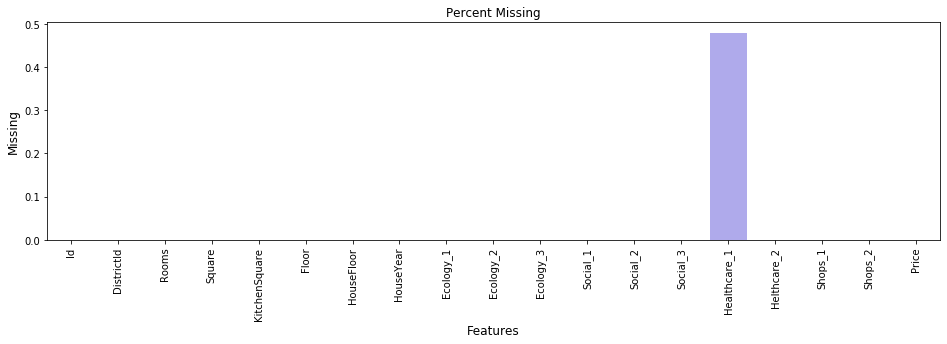

In [17]:
nan_df = (df.isna().sum() / df.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [18]:
def model_nan(X): 

    # Модель RandomForestRegressor для заполнения Healthcare_1
    # параметры для создания 2 датасетов: на df_fool модель будет обучаться 
    param=df.corr()['Healthcare_1']
    param_df_fool = list(param[(param>0.05) & (param != 1) & (param.index != 'Price')].index) + ['Healthcare_1'] + ['Id']
    param_df_null = list(param[(param>0.05) & (param != 1) & (param.index != 'Price')].index) + ['Id']
    
    # датасет с не заполненным значением Healthcare_1
    df_null = X.loc[(X['Healthcare_1'].isnull()) | (X['Healthcare_1'] == 0.0)][param_df_null]
    # датасет с заполненным значением Healthcare_1, на котором будет происходить обучение
    df_fool = X.loc[(X['Healthcare_1'].notnull()) & (X['Healthcare_1'] != 0.0)][param_df_fool]
    
    # датафрейм без целевой переменной
    X_t = df_fool[param_df_null]
    # датафрейм с целевой переменной
    y_t = df_fool['Healthcare_1']
    
    # модель RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_depth=20, random_state=42)
    # обучение модели на полном df_fool
    rf.fit(X_t, y_t)
    # предсказание признака 'Healthcare_1' на обученной модели для df_null
    df_null_pred = list(rf.predict(df_null))

    # новый столбец 
    df_null['Healthcare_1'] = df_null_pred
    # заполнение начального датасета df полученным значением Healthcare_1 из датасета df_null
    for i in X['Id']:
        list_df = list(X.loc[(X['Id'] == i)]['Healthcare_1'])
        if str(list_df[0]) == 'nan' or list_df[0] == 0.0:
            list_df_null = list(round(df_null.loc[(df_null['Id'] == i)]['Healthcare_1'], 1))
            X.loc[X['Id'] == i, 'Healthcare_1'] = list_df_null[0]   
    
    return X

In [19]:
fdf = model_nan(fdf)
df = model_nan(df)

## IV. PCA

In [20]:
df.corr().Price.sort_values()

Ecology_1       -0.058381
Ecology_3       -0.052585
Id               0.009880
Ecology_2        0.022379
HouseYear        0.036574
Shops_2          0.070388
Social_3         0.074878
Floor            0.113605
HouseFloor       0.115733
Shops_1          0.180876
Healthcare_1     0.186238
Social_2         0.239226
Helthcare_2      0.253090
Social_1         0.263286
KitchenSquare    0.323550
Rooms            0.574272
Square           0.574338
Price            1.000000
Name: Price, dtype: float64

In [21]:
def reduce_dims(df, dims=2, name='component'):
    
    dim_reducer = PCA(n_components=dims, random_state=42)
    components = dim_reducer.fit_transform(df)
        
    colnames = [name + '_' + str(i) for i in range(1, dims+1)]
    
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [22]:
def pca_components(X):
    
    # Ecology
    pca_ecology = X[['Ecology_1', 'Ecology_2', 'Ecology_3']]
    dim_reducer_eco_1d, components_eco_1d = reduce_dims(pca_ecology, dims=1)
    X['Ecology'] = np.round(components_eco_1d.values)
    X.drop('Ecology_1', axis=1, inplace=True)
    X.drop('Ecology_2', axis=1, inplace=True)
    X.drop('Ecology_3', axis=1, inplace=True)

    # Shops
    pca_shops = X[['Shops_1', 'Shops_2']]
    dim_reducer_shop_1d, components_shop_1d = reduce_dims(pca_shops, dims=1)
    X['Shops'] = np.round(components_shop_1d.values, 3)
    X.drop('Shops_1', axis=1, inplace=True)
    X.drop('Shops_2', axis=1, inplace=True)

    return X

In [23]:
df = pca_components(df)
fdf = pca_components(fdf)

## V. Генерация новых фичей

**Target encoding**

In [24]:
# медианная цена по параметру DistrictId
med_P_D = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'}).\
                        rename(columns={'Price':'med_P_D'})

df = df.merge(med_P_D, on=['DistrictId'], how='left')
fdf = fdf.merge(med_P_D, on=['DistrictId'], how='left')
fdf.fillna(df.med_P_D.median(), inplace=True)

# медианная цена по параметру Social_2
med_P_S2 = df.groupby(['Social_2'], as_index=False).agg({'Price':'median'}).\
                        rename(columns={'Price':'med_P_S2'})

df = df.merge(med_P_S2, on=['Social_2'], how='left')
fdf = fdf.merge(med_P_S2, on=['Social_2'], how='left')
fdf.fillna(df.med_P_S2.median(), inplace=True)

# цена за квадратный метр
df['avg_price'] = np.round(df['Price'] / df['Square'], -2)

# медианная цена за метр по параметру DistrictId
med_P_D_ap = df.groupby(['DistrictId'], as_index=False).agg({'avg_price':'median'}).\
                        rename(columns={'avg_price':'med_P_D_ap'})

df = df.merge(med_P_D_ap, on=['DistrictId'], how='left')
fdf = fdf.merge(med_P_D_ap, on=['DistrictId'], how='left')
fdf.fillna(df.med_P_D_ap.median(), inplace=True)

# медианная цена за метр по параметру Social_2
med_P_S2_ap = df.groupby(['Social_2'], as_index=False).agg({'avg_price':'median'}).\
                        rename(columns={'avg_price':'med_P_S2_ap'})

df = df.merge(med_P_S2_ap, on=['Social_2'], how='left')
fdf = fdf.merge(med_P_S2_ap, on=['Social_2'], how='left')
fdf.fillna(df.med_P_S2_ap.median(), inplace=True)

## VI. Модель предсказания целевой переменной Price

In [25]:
df.set_index('Id', inplace=True)
fdf.set_index('Id', inplace=True)

list_out = ['Price', 'DistrictId', 'avg_price', 'Helthcare_2', 'Ecology', 'Shops']
param_X = []

for i in df:
     if i not in list_out:
        param_X.append(i)

In [26]:
# датафрейм без целевой переменной
X = df[param_X]
X.head(2)

,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Healthcare_1,med_P_D,med_P_S2,med_P_D_ap,med_P_S2_ap
Id,,,,,,,,,,,,,,
14038,2.0,47.981561,6.0,7.0,9.0,1969,33,7976,5,1388.2,203602.408898,216329.642379,4350.0,4400.0
15053,3.0,65.683640,8.0,7.0,9.0,1978,46,10309,1,240.0,210694.850106,205321.620544,4400.0,4400.0


In [27]:
# финальный датафрейм без целевой переменной
X_pred = fdf[param_X]
X_pred.head(2)

,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Healthcare_1,med_P_D,med_P_S2,med_P_D_ap,med_P_S2_ap
Id,,,,,,,,,,,,,,
725,2.0,49.882643,6.0,6.0,14.0,1972,11,2748,1,452.4,151557.904767,155335.327454,2900.0,3500.0
15856,2.0,69.263183,6.0,1.0,6.0,1977,6,1437,3,1679.2,195610.960042,159768.174822,3300.0,2700.0


In [28]:
# целевая переменная
y = df['Price']
y.head()

Id
14038    184966.930730
15053    300009.450063
4765     220925.908524
5809     175616.227217
10783    150226.531644
Name: Price, dtype: float64

In [29]:
df.corr().Price.sort_values(ascending=False)

Price            1.000000
avg_price        0.623969
Square           0.574338
Rooms            0.574272
med_P_D          0.567552
med_P_S2         0.559714
med_P_D_ap       0.527179
med_P_S2_ap      0.526150
KitchenSquare    0.323550
Social_1         0.263286
Helthcare_2      0.253090
Social_2         0.239226
Healthcare_1     0.186238
Shops            0.180894
HouseFloor       0.115733
Floor            0.113605
Social_3         0.074878
HouseYear        0.036574
Ecology         -0.058412
Name: Price, dtype: float64

**Модель RandomForestRegressor**

In [30]:
rf = RandomForestRegressor(n_estimators=350, max_depth=22, n_jobs=-1, random_state=42)

cv_score = cross_val_score(rf, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))
# R2: 0.750 +- 0.020

R2: 0.750 +- 0.020


R2:	0.966
RMSE:	17158.714
MSE:	294421454.185


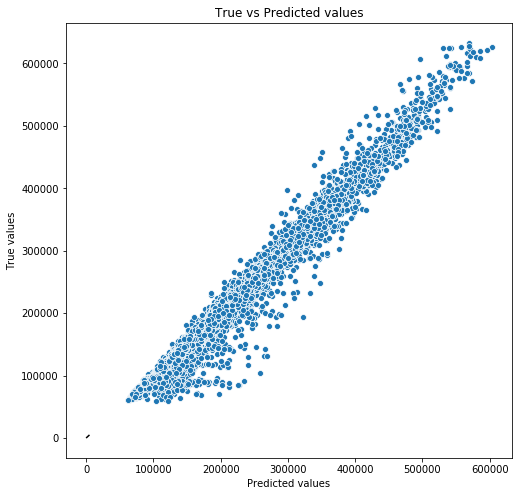

In [31]:
# обучение модели на полных данных
rf.fit(X, y)
# предсказание на полных данных
y_pred_rf = rf.predict(X)
evaluate_preds(y, y_pred_rf)
# R2: 0.966
# R2 на Kaggle: 0.74449

In [32]:
feature_importances = pd.DataFrame(zip(X.columns, rf.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.422913
12,med_P_D_ap,0.145712
10,med_P_D,0.112901
13,med_P_S2_ap,0.093292
11,med_P_S2,0.043209
5,HouseYear,0.033157
0,Rooms,0.032121
4,HouseFloor,0.026692
3,Floor,0.023825
2,KitchenSquare,0.019793


**Модель VotingRegressor**

In [33]:
model_rf = RandomForestRegressor(n_estimators=350, max_depth=22, n_jobs=-1, random_state=42)

model_lgbm = LGBMRegressor(max_depth=4, min_samples_leaf=10, n_estimators=300, random_state=42)

model_vr = VotingRegressor([('model_1', model_rf), ('model_2', model_lgbm)])

cv_score = cross_val_score(model_vr, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42))

mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))
#R2: 0.767 +- 0.022
model_vr.fit(X, y)

R2: 0.767 +- 0.022


VotingRegressor(estimators=[('model_1',
                             RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=22,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=350, n_jobs=-1,
                                                   oob_score=False,
                                                   random_state=42, verbose=0,
           

R2:	0.921
RMSE:	26076.502
MSE:	679983960.237


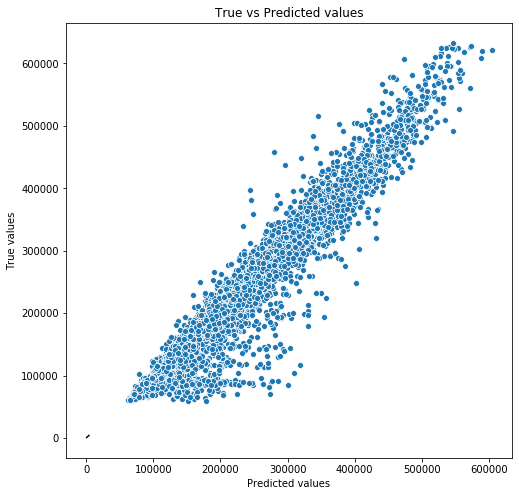

In [34]:
y_pred_vr = model_vr.predict(X)
evaluate_preds(y, y_pred_vr)
# R2: 0.921
# R2 на Kaggle: 0.75737

## VII. Предсказание и сохранение финальных данных

In [35]:
# на модели RandomForestRegressor
f_pred = rf.predict(X_pred)
final_df = pd.DataFrame()
final_df['Id'] = fdf.index
final_df['Price'] = f_pred
final_df.to_csv('predict_rf.csv', index=False, encoding='utf-8')
# R2 на Kaggle: 0.74505

# на модели VotingRegressor
f_pred = model_vr.predict(X_pred)
final_df = pd.DataFrame()
final_df['Id'] = fdf.index
final_df['Price'] = f_pred
final_df.to_csv('predict_vr.csv', index=False, encoding='utf-8')
# R2 на Kaggle: 0.75460